### Analiza częstotliwości występowania słów i sprawdzenie, czy spełnione jest prawo Zipfa (czy iloczyn rangi i częstotliwości jest w przybliżeniu stały).

In [1]:
import re
from collections import Counter

with open("czech-text.txt", encoding="utf-8") as file:
    raw_text = file.read().lower()

pattern = r'\b\w+\b'
tokens = re.findall(pattern, raw_text)

word_counts = Counter(tokens)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

sorted_counts = list(word_counts.values())
sorted_counts.sort(reverse=True)

rank_positions = np.arange(1, len(sorted_counts) + 1)


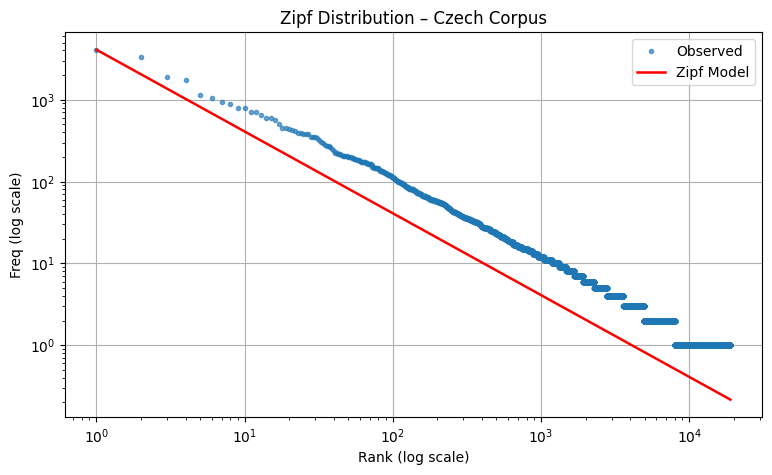

In [3]:
top_freq = sorted_counts[0]
zipf_line = top_freq / rank_positions

plt.figure(figsize=(9,5))
plt.loglog(rank_positions, sorted_counts, '.', alpha=0.65, label="Observed")
plt.loglog(rank_positions, zipf_line, color="red", linewidth=1.8, label="Zipf Model")
plt.xlabel("Rank (log scale)")
plt.ylabel("Freq (log scale)")
plt.title("Zipf Distribution – Czech Corpus")
plt.grid(True)
plt.legend()
plt.show()


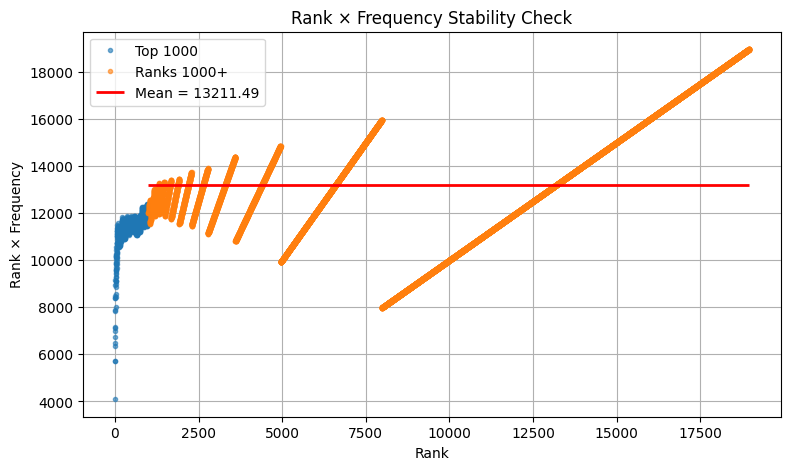

In [4]:
paired = list(zip(rank_positions, sorted_counts))
tail_vals = [a * b for a, b in paired[999:]]
const_est = np.mean(tail_vals)

plt.figure(figsize=(9,5))
plt.plot(rank_positions[:1000], [a*b for a, b in paired[:1000]], '.', alpha=0.6, label="Top 1000")
plt.plot(rank_positions[999:], tail_vals, '.', alpha=0.6, label="Ranks 1000+")
plt.hlines(const_est, xmin=1000, xmax=len(sorted_counts), colors='red', linewidth=2, label=f"Mean = {const_est:.2f}")
plt.title("Rank × Frequency Stability Check")
plt.xlabel("Rank")
plt.ylabel("Rank × Frequency")
plt.grid(True)
plt.legend()
plt.show()


In [5]:
# Wnioski:
# 1. Rozkład częstości słów w czeskim korpusie ogólnie potwierdza prawo Zipfa, zwłaszcza dla słów o wysokich rangach (rzadszych). 
# W tych obszarach częstość spada mniej więcej odwrotnie proporcjonalnie do rangi.
# 2. Na wykresie log-log zależność częstotliwości od rangi przyjmuje kształt zbliżony do prostej o nachyleniu bliskim −1, 
# co wskazuje na typową zgodność z prawem Zipfa dla dużych zbiorów tekstowych.
# 3. Iloczyn rangi i częstości (rank × frequency) stabilizuje się dopiero od ok. 1000 pozycji wzwyż, 
# oscylując wokół średniej wartości C wyznaczonej dla tego zakresu. Widoczne są jednak lokalne skoki, wynikające m.in. 
# z dużej liczby odmian fleksyjnych w języku czeskim oraz różnorodności stylistycznej połączonych tekstów.
# 4. Prawo Zipfa stanowi dobre przybliżenie, lecz nie jest spełnione idealnie dla wszystkich słów, zwłaszcza w początkowej części listy, 
# gdzie znajdują się słowa bardzo częste (wyrazy funkcjonalne). Dodatkowe odchylenia pojawiają się także w wyniku łączenia wielu książek o 
# różnych stylach, strukturach i słownictwie.

### Zastanówmy się, jaki procent słownictwa należy opanować, aby zrozumieć 90% przeciętnego zdania.

In [6]:
unique_count = len(word_counts)
total_count = len(tokens)
unique_count, total_count

(18957, 101949)

In [7]:
needed = 0
covered = 0
cutoff = 0.9 * total_count

for rank, amount in paired:
    if covered >= cutoff:
        break
    needed += 1
    covered += amount

print(f"Aby zrozumieć 90% tekstu, wystarczy znać {needed} słów z {unique_count}.")
print(f"Daje to pokrycie {covered} spośród {total_count} wszystkich wystąpień słów.")

Aby zrozumieć 90% tekstu, wystarczy znać 8763 słów z 18957.
Daje to pokrycie 91755 spośród 101949 wszystkich wystąpień słów.


### Określamy tzw. rdzeń języka – około 50 słów z największą liczbą sąsiadów w grafie współwystępowania, prawdopodobnie pełniących funkcje gramatyczne. Graf jest nieskierowany, nie ma znaczenia, czy znajduje się przed, czy po nim.

In [8]:
pairs = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

print("Pierwsze pary słów:", pairs[:10])

Pierwsze pary słów: [('valašsko', 'tichý'), ('tichý', 'a'), ('a', 'zadumaný'), ('zadumaný', 'kraj'), ('kraj', 'kraj'), ('kraj', 'vysokých'), ('vysokých', 'kopců'), ('kopců', 'protáhlých'), ('protáhlých', 'strání'), ('strání', 'hlubokých')]


In [9]:
import networkx as nx

graph = nx.Graph()
graph.add_edges_from(pairs)

print("Liczba węzłów (unikalnych słów):", graph.number_of_nodes())
print("Liczba połączeń (współwystąpień):", graph.number_of_edges())

Liczba węzłów (unikalnych słów): 18957
Liczba połączeń (współwystąpień): 73029


In [10]:
deg = graph.degree()
deg_map = {node: val for node, val in deg}

ranked = sorted(deg_map.items(), key=lambda x: x[1], reverse=True)
core50 = ranked[:50]

print("Najbardziej połączone słowa w czeskim korpusie:")
for w, d in core50:
    print(f"{w} → {d}")

Najbardziej połączone słowa w czeskim korpusie:
a → 3713
se → 2732
na → 1769
v → 1214
to → 1206
do → 1005
ale → 975
je → 951
že → 853
s → 831
k → 712
si → 689
tak → 672
co → 583
za → 582
už → 567
jako → 565
z → 558
i → 541
když → 522
po → 484
řekl → 464
jak → 457
byl → 448
ho → 443
jen → 443
slávek → 418
by → 418
o → 407
lojza → 400
mu → 376
bylo → 371
tam → 340
jsem → 336
ještě → 330
u → 325
ani → 313
jeho → 310
jim → 305
až → 304
tu → 300
však → 294
od → 294
byla → 291
já → 273
bude → 264
aby → 261
ty → 258
chlapci → 257
před → 257


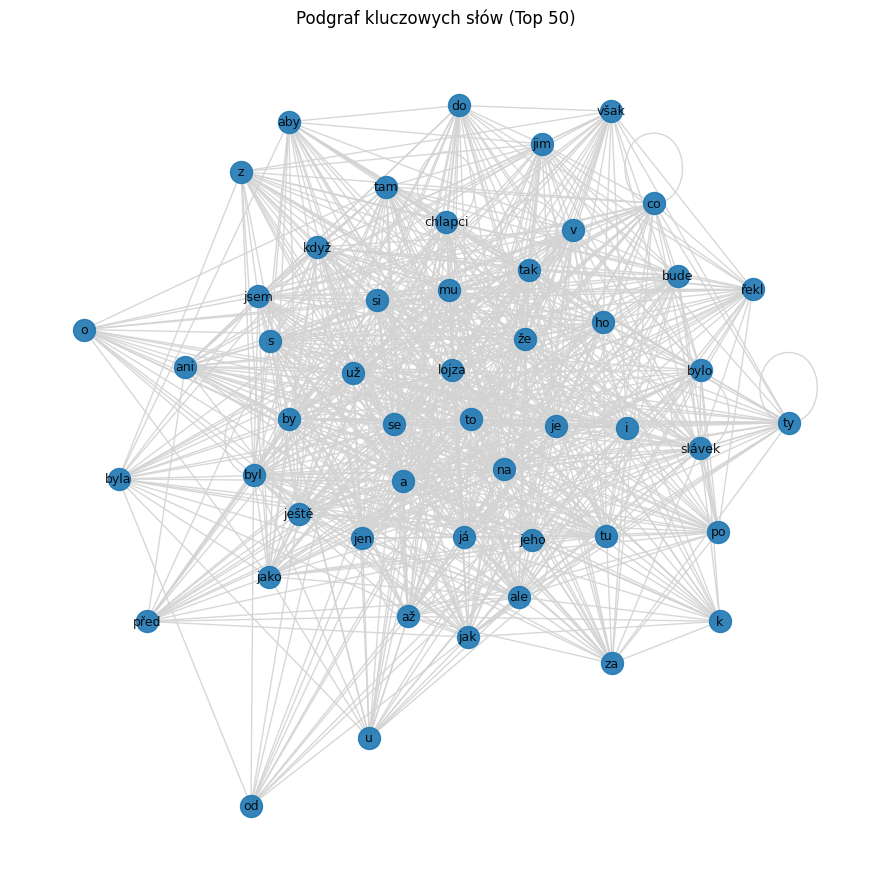

In [11]:
core_nodes = [w for w, d in core50]

mini_graph = graph.subgraph(core_nodes)

plt.figure(figsize=(11, 11))
layout = nx.spring_layout(mini_graph, k=0.4, iterations=50)
nx.draw_networkx(mini_graph, layout, node_size=250, font_size=9, edge_color="lightgray", alpha=0.9)
plt.title("Podgraf kluczowych słów (Top 50)")
plt.axis("off")
plt.show()